<a href="https://colab.research.google.com/github/covinolab/tomo_sbi/blob/main/Debug_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
import os
import sys
import torch
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial.transform import Rotation
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
# import MDAnalysis as mda
import mrcfile
# import umap

# import cryo_sbi.inference.train_npe_model as train_npe_model
# import cryo_sbi.utils.estimator_utils as est_utils
# import cryo_sbi.utils.image_utils as img_utils

# Get the path to the directory containing the module you want to import
# module_dir = '../src/cryo_sbi/wpa_simulator/'
module_dir = '../src/cryo_sbi/'

# Add this directory to the system path
sys.path.append(module_dir)

# from cryo_em_simulator import CryoEmSimulator
import train_npe_model_3d as train_npe_model
import utils_3d.estimator_utils_3d as est_utils_3d
from cryo_em_simulator_3d import CryoEmSimulator_3d

# import utils.image_utils as img_utils
import utils_3d.generate_models_3d as generate_models
from utils_3d.test_data_utils_3d import extract_overlapping_crops, calculate_snr



/home/arghittu/anaconda3/envs/cryoet_sbi/lib/python3.9/site-packages/Bio/Application/__init__.py:40: BiopythonDeprecationWarning: The Bio.Application modules and modules relying on it have been deprecated.

Due to the on going maintenance burden of keeping command line application
wrappers up to date, we have decided to deprecate and eventually remove these
modules.

We instead now recommend building your command line and invoking it directly
with the subprocess module.
  warnings.warn(


### Make the models

Here we are creating the molecular models.



In [ ]:
# Generate the pytorch tensor from PDB files for P116 and Ribosome 80s
# generate_models.pdb_parser("8A9B.pdb", 1, 'P116_8a9b.pt')
# generate_models.pdb_parser("Ribosome/human_ribosome80s_4ugo.pdb", 1, 'Ribosome/human_ribosome80s_4ugo.pt')

In [ ]:


# downsample the models (every 4 atoms) - hsp90
# hsp_90 = torch.load("hsp90_models.pt")[:,:,::4]
# torch.save(hsp_90,"hsp90_models_3d.pt")




# downsample the models (every i*2 atoms with i E [2,21]) - ribosome 80s

pdb_ribosome = torch.load("Ribosome/human_ribosome80s_4ugo.pt")[:,:,::2]
ribosome_pad=torch.Tensor()

for i in range(2,11,1):
    ribosome_downsampled = pdb_ribosome[:,:,::i]
    padding = torch.full((pdb_ribosome.shape[0], pdb_ribosome.shape[1], (pdb_ribosome.shape[2] - ribosome_downsampled.shape[2])), float(0))
    ribosome_downsampled_pad = torch.cat((ribosome_downsampled, padding), dim=2)
    ribosome_pad = torch.cat((ribosome_pad, ribosome_downsampled_pad), dim=0)

ribosome = torch.cat((pdb_ribosome, ribosome_pad), dim=0)
print(ribosome.shape)
torch.save(ribosome,"Ribosome/human_ribosome80s_4ugo_downsampled.pt")

In [ ]:
# noising the structure - ribosome 80s

# pdb_ribosome = torch.load("Ribosome/human_ribosome80s_4ugo.pt")[:,:,::2]

# noise_levels = np.arange(-0.5, 0.5, 0.05)
# torch.save(noise_levels, "Ribosome/noise_levels.pt")

# noised_ribosome_models=torch.Tensor(noise_levels.shape[0], pdb_ribosome.shape[1], pdb_ribosome.shape[2])


# for i in noise_levels:

#     noise_array = torch.rand_like(pdb_ribosome) * i
#     rescaled_noise_array = noise_array * (pdb_ribosome.max() - pdb_ribosome.min())
#     noised_ribosome = pdb_ribosome + rescaled_noise_array
#     noised_ribosome_models[noise_levels == i,:,:] = noised_ribosome


# print(pdb_ribosome.shape, noised_ribosome_models.shape)
# torch.save(noised_ribosome_models,"Ribosome/human_ribosome80s_4ugo_noised.pt")

##### Visualize the models

### Run first simulation

We will now simulate the cryo-EM images with our generated models.
The simulation is done by the class `CryoEmSimulator`. And the simulation is run by the function `simulate` function.
The class `CryoEmSimulator` takes as input a config file with the simulation parameters. The config file used here is `simulation_parameters.json`.

The following parameters are used in the simulation:

```
simulation_parameters.json

{
    "N_PIXELS": 64,             --> size of the image
    "PIXEL_SIZE": 2.0,          --> pixel size in angstroms
    "SIGMA": [2.0, 2.0],        --> standard deviation of the gaussian
    "MODEL_FILE": "models.pt",  --> file which contains the models
    "SHIFT": 0.0,               --> shift of model center
    "DEFOCUS": [2.0, 2.0],      --> defocus range for the simulation
    "SNR": [0.01, 0.5],         --> signal to noise ratio  for the simulation
    "AMP": 0.1,                 --> amplitude for the ctf
    "B_FACTOR": [1.0, 1.0]      --> b factor for the ctf
}
```

## 3d

In [ ]:
simulator_3d = CryoEmSimulator_3d(
    "simulation_parameters_3d.json", device='cpu'
)  # creating simulator with simulation parameters

Config file loaded. {'N_PIXELS': 64, 'PIXEL_SIZE': 13.481, 'DEPTH_SIZE': 64, 'SIGMA': [4, 5], 'MODEL_FILE': 'Ribosome/human_ribosome80s_4ugo_noised.pt', 'EXP_DATA': 'Ribosome/emd_13835.map', 'SHIFT': 30, 'DEFOCUS': [2.0, 2.0], 'SNR': [0.5, 0.53], 'AMP': 0.1, 'B_FACTOR': [1.0, 1.0]}
shift_prior BoxUniform(low: torch.Size([3]), high: torch.Size([3]))


In [ ]:
volumes, parameters = simulator_3d.simulate(
    num_sim=10, return_parameters=True
)  # simulating images and save parameters

In [ ]:
index = parameters[0]  # extracting distance from parameters
snr = parameters[-1]  # extracting snr from parameters

In [ ]:
index

tensor([[ 0.4891],
        [ 7.9179],
        [ 5.5495],
        [ 3.3062],
        [18.4032],
        [ 2.2934],
        [ 6.2594],
        [ 9.6314],
        [12.8007],
        [17.4512]])

#### Visualize the simulated volumes

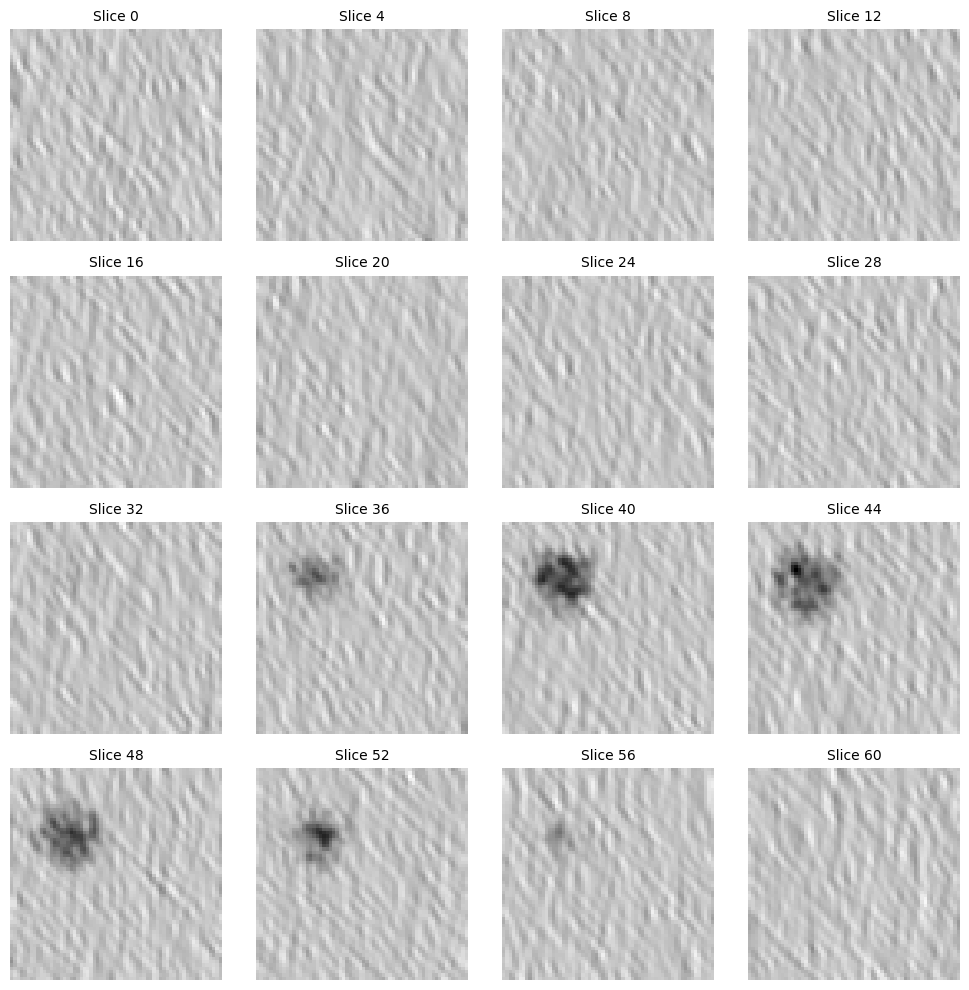

In [ ]:
single_volume = volumes[4]  # Shape: [depth, height, width]

fig, axes = plt.subplots(4, 4, figsize=(10, 10))

# Choose slices to display - for example, evenly spaced through the volume
depth = single_volume.shape[2]
slice_indices = torch.linspace(0, depth, 64).long()  # 16 evenly spaced slices

for ax, idx in zip(axes.flatten(), slice_indices[::4]):
    slice_2d = single_volume[:, idx, :].float().numpy()  # Get a 2D slice of the volume

    # Plot the slice
    ax.imshow(slice_2d, cmap='gray',vmin=single_volume.min(), vmax=single_volume.max())
    ax.set_title(f'Slice {idx.item()}', fontsize=10)
    ax.axis('off')

plt.tight_layout()
plt.show()

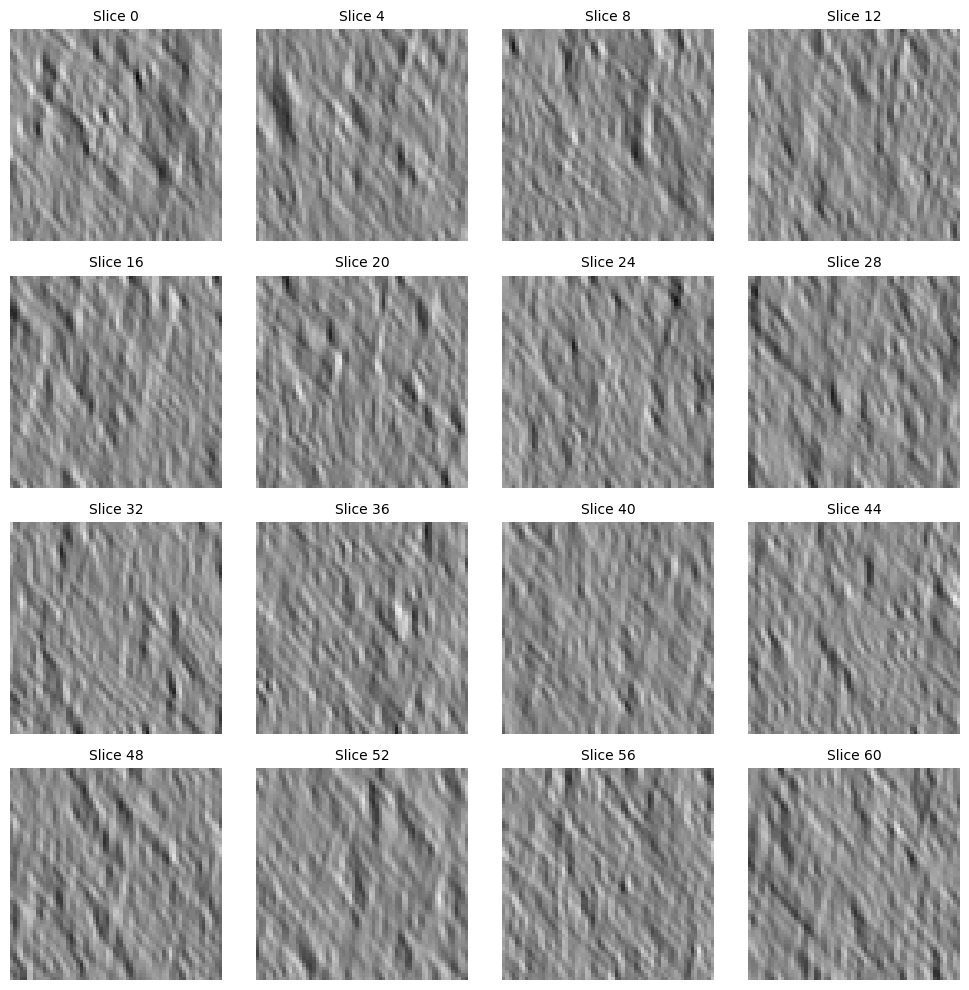

In [ ]:
# single_volume = test_crops_standardized[3]  # Shape: [depth, height, width]

# fig, axes = plt.subplots(4, 4, figsize=(10, 10))

# # Choose slices to display - for example, evenly spaced through the volume
# depth = single_volume.shape[2]
# slice_indices = torch.linspace(0, depth, 64).long()  # 16 evenly spaced slices

# for ax, idx in zip(axes.flatten(), slice_indices[::4]):
#     slice_2d = single_volume[:, idx, :].float().numpy()  # Get a 2D slice of the volume

#     # Plot the slice
#     ax.imshow(slice_2d, cmap='gray',vmin=single_volume.min(), vmax=single_volume.max())
#     ax.set_title(f'Slice {idx.item()}', fontsize=10)
#     ax.axis('off')

# plt.tight_layout()
# plt.show()

In [ ]:
# single_volume = volumes[5]  # Shape: [depth, height, width]

# fig, axes = plt.subplots(4, 4, figsize=(10, 10))

# # Choose slices to display - for example, evenly spaced through the volume
# depth = single_volume.shape[2]
# slice_indices = torch.linspace(0, depth, 64).long()  # 16 evenly spaced slices



# for ax, idx in zip(axes.flatten(), slice_indices[::4]):
#     slice_2d = single_volume[:, idx, :].float().numpy()  # Get a 2D slice of the volume

#     # Plot the slice
#     ax.imshow(slice_2d, cmap='gray',)# vmin=-0.00005, vmax=0.00005)
#     ax.set_title(f'Slice {idx.item()}', fontsize=10)
#     ax.axis('off')

# plt.tight_layout()
# plt.show()

In [ ]:
# loading experimental data for test inference
experimental_ribosome_tomo = mrcfile.read("Ribosome/emd_13835.map")

In [ ]:
# experimental_ribosome_tomo.shape

In [ ]:

exp_volume_tensor = torch.tensor(experimental_ribosome_tomo, device='cpu')
# paddded_tomo = pad_volume(experimental_ribosome_tomo.data, 64)
crops, indeces = extract_overlapping_crops(torch.tensor(experimental_ribosome_tomo), 64, 32)

In [ ]:
test_crops = crops[0::1136]
test_crops.shape

torch.Size([11, 64, 64, 64])

In [ ]:
# snr = calculate_snr(exp_volume_tensor,exp_volume_tensor.device)
# snr

In [ ]:
#Get Pixel_size of experimental data from header of mrc file

# mrc = mrcfile.open("Ribosome/emd_13835.map")
# # for field in mrc.header.dtype.names:
# #     print(repr(field)+": "+repr(mrc.header[field]))

# pixel_spacing_x = mrc.header["cella"].item()[0]/mrc.header["nx"].item()
# pixel_spacing_y = mrc.header["cella"].item()[1]/mrc.header["ny"].item()
# pixel_spacing_z = mrc.header["cella"].item()[2]/mrc.header["nz"].item()
# print(pixel_spacing_x, pixel_spacing_y, pixel_spacing_z)


In [ ]:
# crops.shape

In [ ]:
# i=0
# while i in range(crops.shape[0]):
#     if -crops[i].mean() == -crops.mean(dim=(1,2,3)).max():
#         print(i)
#         break
#     i+=1

In [ ]:
# crop = -crops[1101]
# fig, axes = plt.subplots(4, 4, figsize=(10, 10))

# depth = crop.shape[2]
# slice_indices = torch.linspace(0, depth, 64).long()



# for ax, idx in zip(axes.flatten(), slice_indices[::4]): # 16 evenly spaced slices
#     slice_2d = crop[:, idx, :]  # Get a 2D slice of the volume

#     # Plot the slice
#     ax.imshow(slice_2d, cmap='gray')#,vmin=crop.min(), vmax=crop.max())
#     ax.set_title(f'Slice {idx.item()}', fontsize=10)
#     ax.axis('off')

# plt.tight_layout()
# plt.show()

In [ ]:
# with mrcfile.new("Ribosome/simulated_volume.mrc", overwrite=True) as mrc:
#     mrc.set_data(single_volume.numpy().astype(np.float32))

In [ ]:
# with mrcfile.new("test_volumes/single_volume_hsp90.mrc", overwrite=True) as mrc:
#     mrc.set_data(single_volume.numpy().astype(np.float32))


In [ ]:
# with mrcfile.open("test_volumes/single_volume.mrc", mode='r') as mrc:
#     print(mrc.data.shape)

### Train cryoSBI posterior

We will now train the cryoSBI posterior to infer the distance between the atoms from the simulated images.
The training is done with the function `npe_train_no_saving` which simulates images and simultaneously trains the posterior.
The function takes as input the config file `training_parameters.json` which contains the training and neural network parameters.
The function also takes as input the config file `simulation_parameters.json` which contains the simulation parameters used to simulate the images.


```
training_parameters.json
```

```
{
    "EMBEDDING": "ConvEncoder_Tutorial",    --> embedding network for the images
    "OUT_DIM": 128,                         --> dimension of the embedding
    "NUM_TRANSFORM": 5,                     --> number of transformations
    "NUM_HIDDEN_FLOW": 5,                   --> number of hidden layers in the flow
    "HIDDEN_DIM_FLOW": 128,                 --> dimension of the hidden layers in the flow
    "MODEL": "NSF",                         --> type of flow
    "LEARNING_RATE": 0.0003,                --> learning rate
    "CLIP_GRADIENT": 5.0,                   --> gradient clipping
    "THETA_SHIFT": 50,                      --> shift of the model center
    "THETA_SCALE": 50,                      --> scale of the model
    "BATCH_SIZE": 32                        --> batch size
}
```


In [ ]:
train_npe_model.npe_train_no_saving(
    "simulation_parameters_3d.json",
    "training_parameters.json",
    10,
    "Ribosome_estimator_carreira_noised.pt",  # name of the estimator file
    "Ribosome_carreira_noised.loss",  # name of the loss file
    n_workers=4,  # number of workers for data loading
    device="cuda",  # device to use for training and simulation
    saving_frequency=5,  # frequency of saving the model
    simulation_batch_size=10,  # batch size for simulation
)

shift_prior BoxUniform(low: torch.Size([3]), high: torch.Size([3]))
Training neural netowrk:


 50%|█████     | 5/10 [2:00:06<2:00:06, 1441.20s/epoch, loss=-0.761]


KeyboardInterrupt: 

##### Visualize the loss after training

Text(0, 0.5, 'Loss')

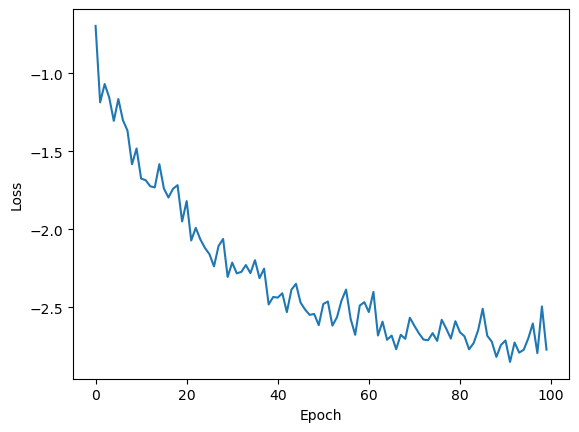

In [ ]:
plt.plot(torch.load("Ribosome_carreira.loss"))
plt.xlabel("Epoch")
plt.ylabel("Loss")

### Evaluate the posterior on our simulated images

We will now evaluate the trained posterior on our simulated images.
For each simulated image we will infer the distance between the atoms and compare it to the true distance, by sampling from the posterior.

In [ ]:
sim_volumes = torch.Tensor(10,64,64,64)
sim_volumes[0,:,:,:] = torch.Tensor(mrcfile.read("Ribosome/single_volume0_carreiraCNN.mrc"))
sim_volumes[1,:,:,:] = torch.Tensor(mrcfile.read("Ribosome/single_volume1_carreiraCNN.mrc"))
sim_volumes[2,:,:,:] = torch.Tensor(mrcfile.read("Ribosome/single_volume2_carreiraCNN.mrc"))
sim_volumes[3,:,:,:] = torch.Tensor(mrcfile.read("Ribosome/single_volume3_carreiraCNN.mrc"))
sim_volumes[4,:,:,:] = torch.Tensor(mrcfile.read("Ribosome/single_volume4_carreiraCNN.mrc"))
sim_volumes[5,:,:,:] = torch.Tensor(mrcfile.read("Ribosome/single_volume5_carreiraCNN.mrc"))
sim_volumes[6,:,:,:] = torch.Tensor(mrcfile.read("Ribosome/single_volume6_carreiraCNN.mrc"))
sim_volumes[7,:,:,:] = torch.Tensor(mrcfile.read("Ribosome/single_volume7_carreiraCNN.mrc"))
sim_volumes[8,:,:,:] = torch.Tensor(mrcfile.read("Ribosome/single_volume8_carreiraCNN.mrc"))
sim_volumes[9,:,:,:] = torch.Tensor(mrcfile.read("Ribosome/single_volume9_carreiraCNN.mrc"))


In [ ]:
torch.tensor.unsqueeze(sim_volumes, 1).shape

In [ ]:
#Standardize experimental data
test_crops_standardized = (test_crops - test_crops.mean(dim=(1,2,3)).unsqueeze(-1).unsqueeze(-1).unsqueeze(-1)) / test_crops.std(dim=(1,2,3)).unsqueeze(-1).unsqueeze(-1).unsqueeze(-1)

In [ ]:
posterior = est_utils_3d.load_estimator(
    "training_parameters.json",
    "Ribosome_estimator_carreira.pt",
    device="cuda",
)

In [ ]:
samples = est_utils_3d.sample_posterior(
    estimator=posterior,
    images=test_crops_standardized,
    num_samples=15000,
    batch_size=8,
    device="cuda",
)

In [ ]:
# log_probs_samples = est_utils_3d.evaluate_log_prob(
#     estimator=posterior,
#     images=-test_crops,
#     theta=torch.zeros(test_crops.shape[0], test_crops.shape[0],1),
#     batch_size=11,
#     device="cuda",
# )

In [ ]:
print(sim_volumes.std(), sim_volumes.mean())
print(test_crops_standardized.std(), test_crops_standardized.mean())

tensor(0.9276) tensor(-1.1176e-09)
tensor(1.0000) tensor(-2.5611e-09)


In [ ]:
import zuko
zuko.flows.NSF?

Init signature: zuko.flows.NSF(features: int, context: int = 0, bins: int = 8, **kwargs)
Docstring:     
Creates a neural spline flow (NSF) with monotonic rational-quadratic spline
transformations.

By default, transformations are fully autoregressive. Coupling transformations
can be obtained by setting :py:`passes=2`.

    Spline transformations are defined over the domain :math:`[-5, 5]`. Any feature
    outside of this domain is not transformed. It is recommended to standardize
    features (zero mean, unit variance) before training.

See also:
    :class:`zuko.transforms.MonotonicRQSTransform`

References:
    | Neural Spline Flows (Durkan et al., 2019)
    | https://arxiv.org/abs/1906.04032

Arguments:
    features: The number of features.
    context: The number of context features.
    bins: The number of bins :math:`K`.
    kwargs: Keyword arguments passed to :class:`zuko.flows.autoregressive.MAF`.
Init docstring: Initialize internal Module state, shared by both nn.Module and S

In [ ]:
# parameters[0].cpu()

NameError: name 'parameters' is not defined

Text(0.5, 0.04, 'class')

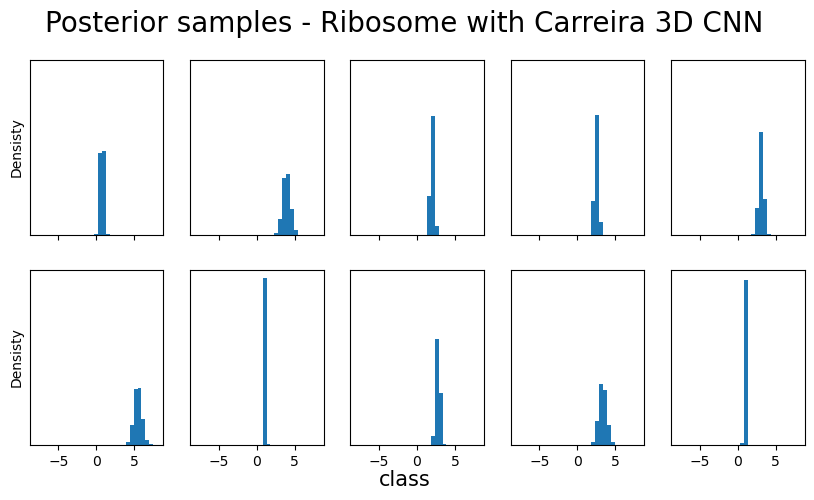

In [ ]:
fig, axes = plt.subplots(2, 5, figsize=(10, 5), sharex=True, sharey=True)

fig.suptitle("Posterior samples - Ribosome with Carreira 3D CNN", fontsize=20)
for idx, ax in enumerate(axes.flatten()):
    ax.hist(samples[:, idx].flatten(), bins=np.linspace(-8, 8, 32), density=True, stacked=True)
    #ax.axvline(parameters[0].cpu()[idx], ymax=1, ymin=0, color="red")
    ax.set_ylim(0,1.5)
    ax.set_yticks([])
    if idx==0 or idx==5:
        ax.set_ylabel(f"Densisty")
#set common xlable of the plot
fig.text(0.5, 0.04, 'class', ha='center', va='center', fontsize=15)


Text(0.5, 0.04, 'class')

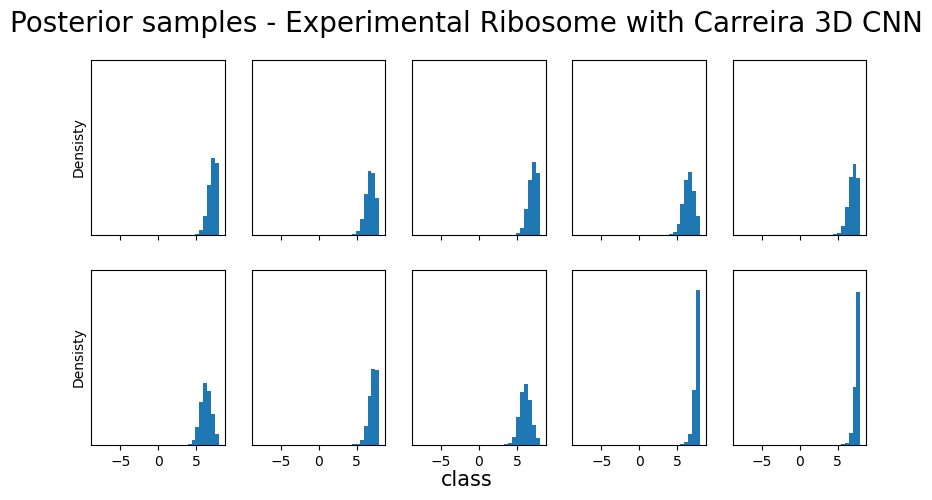

In [ ]:
fig, axes = plt.subplots(2, 5, figsize=(10, 5), sharex=True, sharey=True)

fig.suptitle("Posterior samples - Experimental Ribosome with Carreira 3D CNN", fontsize=20)
for idx, ax in enumerate(axes.flatten()):
    ax.hist(samples[:, idx].flatten(), bins=np.linspace(-8, 8, 32), density=True, stacked=True)
    #ax.axvline(parameters[0].cpu()[idx], ymax=1, ymin=0, color="red")
    ax.set_ylim(0,1.5)
    ax.set_yticks([])
    if idx==0 or idx==5:
        ax.set_ylabel(f"Densisty")
#set common xlable of the plot
fig.text(0.5, 0.04, 'class', ha='center', va='center', fontsize=15)

In [ ]:
# single_volume0 = volumes[0]
# single_volume1 = volumes[1]
# single_volume2 = volumes[2]
# single_volume3 = volumes[3]
# single_volume4 = volumes[4]
# single_volume5 = volumes[5]
# single_volume6 = volumes[6]
# single_volume7 = volumes[7]
# single_volume8 = volumes[8]
# single_volume9 = volumes[9]


In [ ]:
# mrcfile.new("Ribosome/single_volume0_carreiraCNN.mrc", single_volume0.numpy(), overwrite=True)
# mrcfile.new("Ribosome/single_volume1_carreiraCNN.mrc", single_volume1.numpy(), overwrite=True)
# mrcfile.new("Ribosome/single_volume2_carreiraCNN.mrc", single_volume2.numpy(), overwrite=True)
# mrcfile.new("Ribosome/single_volume3_carreiraCNN.mrc", single_volume3.numpy(), overwrite=True)
# mrcfile.new("Ribosome/single_volume4_carreiraCNN.mrc", single_volume4.numpy(), overwrite=True)
# mrcfile.new("Ribosome/single_volume5_carreiraCNN.mrc", single_volume5.numpy(), overwrite=True)
# mrcfile.new("Ribosome/single_volume6_carreiraCNN.mrc", single_volume6.numpy(), overwrite=True)
# mrcfile.new("Ribosome/single_volume7_carreiraCNN.mrc", single_volume7.numpy(), overwrite=True)
# mrcfile.new("Ribosome/single_volume8_carreiraCNN.mrc", single_volume8.numpy(), overwrite=True)
# mrcfile.new("Ribosome/single_volume9_carreiraCNN.mrc", single_volume9.numpy(), overwrite=True)



MrcFile('Ribosome/single_volume9_carreiraCNN.mrc', mode='w+')

In [ ]:
# single_volume0 = test_crops[0]
# single_volume1 = test_crops[1]
# single_volume2 = test_crops[2]
# single_volume3 = test_crops[3]
# single_volume4 = test_crops[4]
# single_volume5 = test_crops[5]
# single_volume6 = test_crops[6]
# single_volume7 = test_crops[7]
# single_volume8 = test_crops[8]
# single_volume9 = test_crops[9]

# mrcfile.new("Ribosome/test_crop0_carreiraCNN.mrc", single_volume0.numpy(), overwrite=True)
# mrcfile.new("Ribosome/test_crop1_carreiraCNN.mrc", single_volume1.numpy(), overwrite=True)
# mrcfile.new("Ribosome/test_crop2_carreiraCNN.mrc", single_volume2.numpy(), overwrite=True)
# mrcfile.new("Ribosome/test_crop3_carreiraCNN.mrc", single_volume3.numpy(), overwrite=True)
# mrcfile.new("Ribosome/test_crop4_carreiraCNN.mrc", single_volume4.numpy(), overwrite=True)
# mrcfile.new("Ribosome/test_crop5_carreiraCNN.mrc", single_volume5.numpy(), overwrite=True)
# mrcfile.new("Ribosome/test_crop6_carreiraCNN.mrc", single_volume6.numpy(), overwrite=True)
# mrcfile.new("Ribosome/test_crop7_carreiraCNN.mrc", single_volume7.numpy(), overwrite=True)
# mrcfile.new("Ribosome/test_crop8_carreiraCNN.mrc", single_volume8.numpy(), overwrite=True)
# mrcfile.new("Ribosome/test_crop9_carreiraCNN.mrc", single_volume9.numpy(), overwrite=True)


MrcFile('Ribosome/test_crop9_carreiraCNN.mrc', mode='w+')

### Plot latent space

In [ ]:
# latent_representations = est_utils_3d.compute_latent_repr(
#     estimator=posterior,
#     images=volumes,
#     batch_size=1000,
#     device="cuda",
# )

In [ ]:
# reducer = umap.UMAP(metric="euclidean", n_components=2, n_neighbors=50)
# latent_vecs_transformed = reducer.fit_transform(latent_representations.numpy())

In [ ]:
# plt.scatter(
#     latent_vecs_transformed[:, 0],
#     latent_vecs_transformed[:, 1],
#     c=dist,
#     cmap="viridis",
#     s=10,
# )
# plt.colorbar(label="Side length")
# plt.xlabel("UMAP 1")
# plt.ylabel("UMAP 2")

In [ ]:
# plt.scatter(
#     latent_vecs_transformed[:, 0],
#     latent_vecs_transformed[:, 1],
#     c=snr,
#     cmap="viridis",
#     s=10,
# )
# plt.colorbar(label="SNR")
# plt.xlabel("UMAP 1")
# plt.ylabel("UMAP 2")